# ECMWF API plugin for EODAG

This tutorial will show you how use eodag to download data from [ECWMF](https://www.ecmwf.int/) using [EcmwfApi](https://eodag.readthedocs.io/en/latest/plugins_reference/generated/eodag.plugins.apis.ecmwf.EcmwfApi.html) `eodag` plugin. The API plugin and this tutorial have been developed in the context of DOMINO-X.

In [1]:
from eodag import EODataAccessGateway, setup_logging

setup_logging(1)  # 0: nothing, 1: only progress bars, 2: INFO, 3: DEBUG
dag = EODataAccessGateway()
dag.set_preferred_provider("ecmwf")

### Search (build download request) from an existing product type:

In this example, we will request data from [TIGGE public dataset](https://www.ecmwf.int/en/research/projects/tigge), using a product type already configured in eodag (`TIGGE_CF_SFC`) or using a custom request to access the same data.

Retrieval request can be customized from ecmwf web ui on https://apps.ecmwf.int/datasets/data/tigge. 

For performance purpose, we add a `param` (total cloud cover, `tcc`) to the request as `TIGGE_CF_SFC` is configured to ask for all available `param` values. See [ecmwf availables parameters](https://apps.ecmwf.int/codes/grib/param-db/). You can add more [MARS keywords](https://confluence.ecmwf.int/display/UDOC/Keywords+in+MARS+and+Dissemination+requests), that will overwrite default values configured for `TIGGE_CF_SFC` product type.

In [2]:
# Request for all parameters
products_from_product_type, total_count = dag.search(
    geom=[-60, 30, -130, 70],
    start="2021-11-01",
    end="2021-11-02",
    productType="TIGGE_CF_SFC",
)
print(
    "%s product built %s, \n having param=%s\n"
    % (
        total_count,
        products_from_product_type[0],
        products_from_product_type[0].properties["param"],
    )
)
# Request for total cloud cover
products_from_product_type, total_count = dag.search(
    geom=[-60, 30, -130, 70],
    start="2021-11-01",
    end="2021-11-02",
    productType="TIGGE_CF_SFC",
    param="tcc",
)
print(
    "%s product built %s, \n having param=%s"
    % (
        total_count,
        products_from_product_type[0],
        products_from_product_type[0].properties["param"],
    )
)

1 product built EOProduct(id=TIGGE_CF_SFC_20211101_53e966f1e6949f5d202f1f53a56f440ba2324f4a, provider=ecmwf), 
 having param=59/134/136/146/147/151/165/166/167/168/172/176/177/179/189/235/228001/228002/228039/228139/228141/228144/228164/228228

1 product built EOProduct(id=TIGGE_CF_SFC_20211101_8c0c3dd73cd23760892e6c5920d1302386a7a1c0, provider=ecmwf), 
 having param=tcc


### Send product retrieval request and download when available

- download performed using [ECMWF credentials](https://github.com/ecmwf/ecmwf-api-client#registered-access-recommended) set in `~/.config/eodag/eodag.yml` as for other EO providers:
```yaml
    ecmwf:
        priority:
        api:
            outputs_prefix: /my/path/to/data/eodag_data
            credentials:
                username: john.doe@csgroup.eu
                password: my-ecmwf-api-access-key
```
- you can check your request status from https://apps.ecmwf.int/webmars/joblist/
- See [ECMWF guidelines](https://confluence.ecmwf.int/display/UDOC/My+request+is+queued+for+a+long+time+-+Web+API+FAQ) if request is queued for a long time

In [3]:
product_path = dag.download(products_from_product_type[0])
product_path

0.00B [00:00, ?B/s]

'/home/anesson/data/eodag_data/TIGGE_CF_SFC_20211101_8c0c3dd73cd23760892e6c5920d1302386a7a1c0'

### Open dataset with xarray and [cfgrib](https://github.com/ecmwf/cfgrib), then plot using matplotlib

In [4]:
import xarray as xr
import matplotlib.pyplot as plt

In [5]:
import os

# the product ouput file to load is the only one located in "product_path" directory
ds = xr.load_dataset(os.path.join(product_path, os.listdir(product_path)[0]), engine="cfgrib")
ds

<xarray.Dataset>
Dimensions:           (latitude: 81, longitude: 141)
Coordinates:
    number            int64 0
    time              datetime64[ns] 2021-11-01
    step              timedelta64[ns] 00:00:00
    entireAtmosphere  float64 0.0
  * latitude          (latitude) float64 70.0 69.5 69.0 68.5 ... 31.0 30.5 30.0
  * longitude         (longitude) float64 230.0 230.5 231.0 ... 299.5 300.0
    valid_time        datetime64[ns] 2021-11-01
Data variables:
    tcc               (latitude, longitude) float32 100.0 100.0 ... 8.406 10.62
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2023-10-20T17:58 GRIB to CDM+CF via cfgrib-0.9.1...

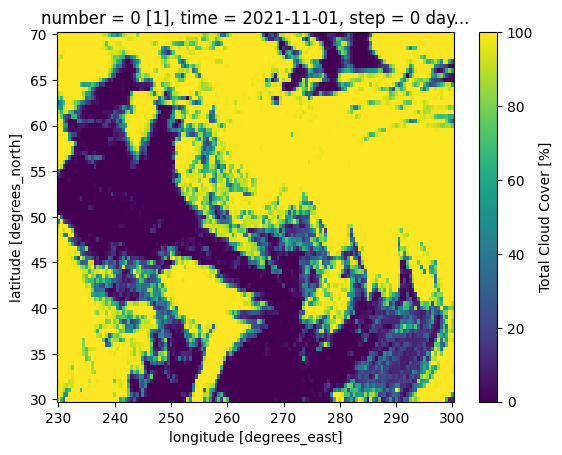

In [6]:
ds.tcc.plot()

### To go further, search using a custom MARS request:

Here we use a set of custom parameters corresponding to `TIGGE_CF_SFC`, which should result to the same request sent to ecmwf.

If you want to eodag from a MARS request obtained from https://apps.ecmwf.int/datasets/data/tigge, you can put in this `ecmwf_req_params` the content of your MARS request without `area` and `date` settings, which must be passed to eodag as `geom`, `start` and `end` parameters.

In [7]:
ecmwf_req_params = {
    "class": "ti",
    "dataset": "tigge",
    "expver": "prod",
    "type": "cf",
    "levtype": "sfc",
    "origin": "ecmf",
    "grid": "0.5/0.5",
    "step": 0,
    "time": "00:00",
    "param": "tcc",
}

products_from_mars_req, total_count = dag.search(
    geom={
        "latmax": 70,
        "lonmax": -130,
        "latmin": 30,
        "lonmin": -60,
    },
    start="2021-11-01",
    end="2021-11-02",
    **ecmwf_req_params
)
# title and downloadLink properties must be the same with the two request methods,
# as they are built from ECMWF request arguments
if (
    products_from_mars_req[0].properties["title"]
    == products_from_product_type[0].properties["title"]
    and products_from_mars_req[0].properties["downloadLink"]
    == products_from_product_type[0].properties["downloadLink"]
):
    print(
        "Request using productType or directly MARS parameters result to the \n",
        "same product title %s \n and downloadLink %s"
        % (
            products_from_mars_req[0].properties["title"],
            products_from_mars_req[0].properties["downloadLink"],
        )
    )

Request using productType or directly MARS parameters result to the 
 same product title TIGGE_CF_SFC_20211101_8c0c3dd73cd23760892e6c5920d1302386a7a1c0 
 and downloadLink https://apps.ecmwf.int/datasets/data/tigge?{"area": ["70.0/-130.0/30.0/-60.0"], "class": "ti", "dataset": "tigge", "date": ["2021-11-01/to/2021-11-01"], "expver": "prod", "grid": "0.5/0.5", "levtype": "sfc", "origin": "ecmf", "param": "tcc", "step": 0, "time": "00:00", "type": "cf"}
